In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load 

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

%matplotlib inline


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


# LOADING DATA

In [11]:
df=pd.read_json('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json',lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [15]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [13]:
df.is_sarcastic.value_counts()


0    14985
1    13634
Name: is_sarcastic, dtype: int64

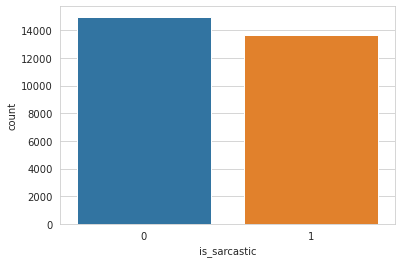

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='is_sarcastic',data=df);


# **MANIPULATE OUR DATA**

In [30]:
# split our data into testing and training
X=df.headline.values
y=df.is_sarcastic.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [32]:
# tokenize data? necessary for words: explain why
text = tf.keras.preprocessing.text.Tokenizer(
    num_words=100000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None,
    document_count=0)
text.fit_on_texts(X_train)

# check
print(text.texts_to_sequences(["The quick brown fox jumped over the lazy dog."]))


[[3, 1772, 1323, 601, 13849, 43, 3, 3255, 194]]


In [33]:
# pad sequences: prevents unequal token lenghths: idk what this means
X_train_seq = text.texts_to_sequences(X_train)
max_seq_len = max(len(x) for x in X_train_seq)
X_train_seq = np.array([np.pad(x, (0, max_seq_len - len(x))) for x in X_train_seq])

X_test_seq = text.texts_to_sequences(X_test)
X_test_seq = np.array([np.pad(x, (0, max_seq_len - len(x))) for x in X_test_seq])



# **CREATE AND TEST MODEL**

In [40]:
# build model: what do these parameters signify
input_dim = len(text.word_index) + 1
output_dim = 1
max_length = 120

model = tf.keras.models.Sequential(
    [tf.keras.layers.Embedding(input_dim, output_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 120, 2)            55254     
_________________________________________________________________
global_average_pooling1d_8 ( (None, 2)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 24)                72        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 25        
Total params: 55,351
Trainable params: 55,351
Non-trainable params: 0
_________________________________________________________________


In [41]:
# training?
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.fit(X_train_seq, y_train, epochs=30, validation_data=(X_test_seq, y_test), verbose=2)


Epoch 1/30
716/716 - 2s - loss: 0.6893 - accuracy: 0.5281 - val_loss: 0.6789 - val_accuracy: 0.5584
Epoch 2/30
716/716 - 2s - loss: 0.6161 - accuracy: 0.7109 - val_loss: 0.5348 - val_accuracy: 0.8061
Epoch 3/30
716/716 - 1s - loss: 0.4452 - accuracy: 0.8476 - val_loss: 0.4194 - val_accuracy: 0.8302
Epoch 4/30
716/716 - 1s - loss: 0.3490 - accuracy: 0.8715 - val_loss: 0.3768 - val_accuracy: 0.8353
Epoch 5/30
716/716 - 1s - loss: 0.2957 - accuracy: 0.8915 - val_loss: 0.3670 - val_accuracy: 0.8363
Epoch 6/30
716/716 - 1s - loss: 0.2571 - accuracy: 0.9048 - val_loss: 0.3484 - val_accuracy: 0.8513
Epoch 7/30
716/716 - 1s - loss: 0.2267 - accuracy: 0.9184 - val_loss: 0.3368 - val_accuracy: 0.8513
Epoch 8/30
716/716 - 1s - loss: 0.1996 - accuracy: 0.9291 - val_loss: 0.3391 - val_accuracy: 0.8555
Epoch 9/30
716/716 - 1s - loss: 0.1775 - accuracy: 0.9370 - val_loss: 0.3444 - val_accuracy: 0.8501
Epoch 10/30
716/716 - 1s - loss: 0.1576 - accuracy: 0.9450 - val_loss: 0.3393 - val_accuracy: 0.8545

In [42]:
# Predict the testing data to find accuracy
pred = model.predict(X_test_seq).round()
print(accuracy_score(y_test, pred))


0.8363032844164919
